In [1]:
import pandas as pd



df_bundesliga = pd.read_csv("/Users/nilsweigeldt/Desktop/capstone2/BWArchenemies/data/bundesliga.csv")


In [2]:
df_bundesliga

,Unnamed: 0,matchday,date,home_team,final_result,away_team,home_goals,away_goals,winner
0,0,1,1963-08-24,Werder Bremen,3-2,Borussia Dortmund,3,2,0
1,1,1,1963-08-24,1. FC Saarbrücken,0-2,1. FC Köln,0,2,2
2,2,1,1963-08-24,TSV 1860 München,1-1,Eintracht Braunschweig,1,1,1
3,3,1,1963-08-24,Eintracht Frankfurt,1-1,1. FC Kaiserslautern,1,1,1
4,4,1,1963-08-24,FC Schalke 04,2-0,VfB Stuttgart,2,0,0
...,...,...,...,...,...,...,...,...,...
18603,18603,34,2024-05-18,1. FC Union Berlin,2-1,SC Freiburg,2,1,0
18604,18604,34,2024-05-18,Eintracht Frankfurt,2-2,RB Leipzig,2,2,1
18605,18605,34,2024-05-18,TSG 1899 Hoffenheim,4-2,Bayern München,4,2,0
18606,18606,34,2024-05-18,VfL Wolfsburg,1-3,1. FSV Mainz 05,1,3,2


Additional EDA and plot interesting graphs on football stats

In [3]:
# Count matches that are either a draw or won by 2 or fewer goals
df_bundesliga['goal_difference'] = abs(df_bundesliga['home_goals'] - df_bundesliga['away_goals'])


total_matches = df_bundesliga.shape[0]

close_matches = df_bundesliga[(df_bundesliga['goal_difference'] <= 2)].shape[0]


percentage_close_matches = (close_matches / total_matches) * 100

print(f"Percentage of matches that end in a draw or are won by two or fewer goals: {percentage_close_matches:.2f}%")

Percentage of matches that end in a draw or are won by two or fewer goals: 80.01%


In [4]:
import plotly.graph_objects as go


labels = ['Close Matches (Draw or Win by 2 or Fewer Goals)', 'Other Matches']
sizes = [round(80.01), round(100 - 80.01)]
colors = ['#636EFA', '#EF553B']

fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=.3, marker=dict(colors=colors))])

fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20)
fig.update_layout(title_text='Distribution of Bundesliga Matches by Outcome')

fig.show()

In [5]:
#Plot how many games were won home, were a draw and were won away 

import altair as alt


df_bundesliga['date'] = pd.to_datetime(df_bundesliga['date'])

df_bundesliga['season_start_year'] = df_bundesliga['date'].apply(lambda x: x.year if x.month >= 8 else x.year - 1)


outcomes_by_season = df_bundesliga.groupby(['season_start_year', 'winner']).size().reset_index(name='count')


outcomes_by_season['winner'] = outcomes_by_season['winner'].map({
    0: 'Home Wins',
    1: 'Draws',
    2: 'Away Wins'
})

outcomes_by_season['season'] = outcomes_by_season['season_start_year'].astype(str) + '-' + (outcomes_by_season['season_start_year'] + 1).astype(str)


chart = alt.Chart(outcomes_by_season).mark_line(point=True).encode(
    x=alt.X('season:O', title='Season', sort=alt.EncodingSortField('season_start_year', order='ascending')),
    y=alt.Y('count:Q', title='Number of Matches'),
    color='winner:N',
    tooltip=['season', 'winner', 'count']
).properties(
    title='Match Outcome Distribution Over the Seasons',
    width=600,
    height=400
)


chart.display()

alt.Chart(...)

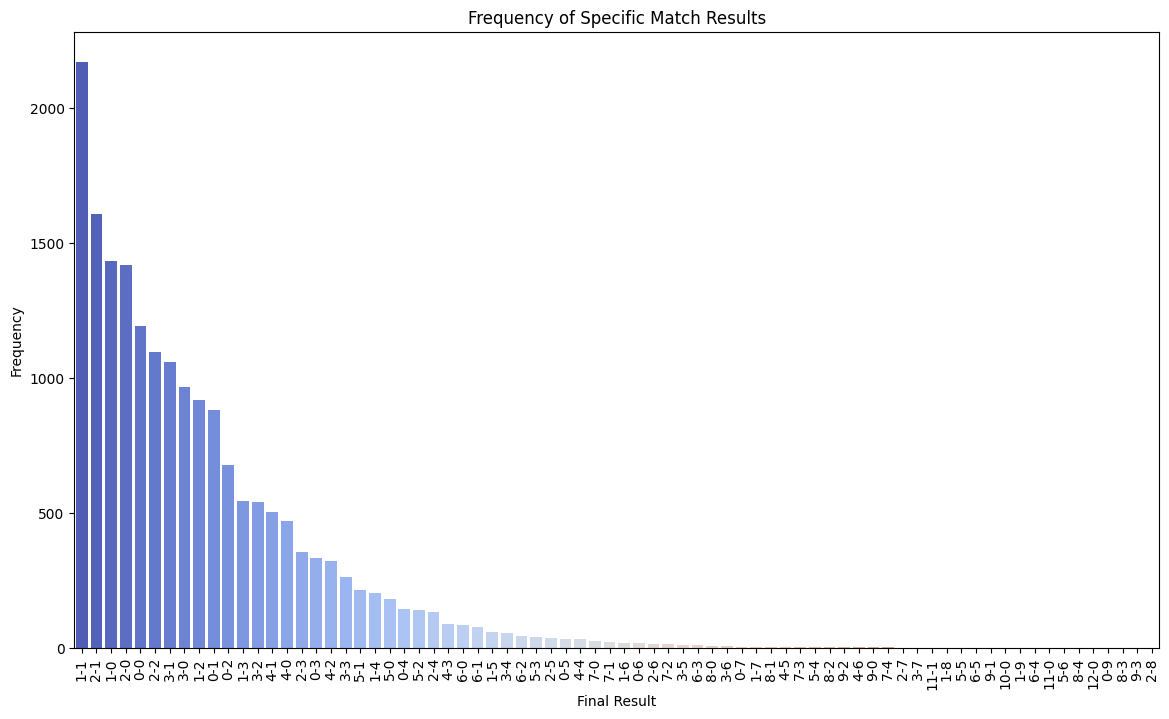

In [6]:
#What was the most frequent score? 

import seaborn as sns
import matplotlib.pyplot as plt

result_counts = df_bundesliga['final_result'].value_counts().reset_index()
result_counts.columns = ['Final Result', 'Count']

plt.figure(figsize=(14, 8))
sns.barplot(x='Final Result', y='Count', data=result_counts, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Frequency of Specific Match Results')
plt.xlabel('Final Result')
plt.ylabel('Frequency')
plt.show()


In [7]:
# Plot total wins by team 

df_bundesliga['season_start_year'] = df_bundesliga['date'].apply(lambda x: x.year if x.month >= 8 else x.year - 1)

home_wins = df_bundesliga[df_bundesliga['winner'] == 0].groupby(['season_start_year', 'home_team']).size().reset_index(name='wins')


away_wins = df_bundesliga[df_bundesliga['winner'] == 2].groupby(['season_start_year', 'away_team']).size().reset_index(name='wins')

home_wins.rename(columns={'home_team': 'team'}, inplace=True)
away_wins.rename(columns={'away_team': 'team'}, inplace=True)

total_wins = pd.concat([home_wins, away_wins]).groupby(['season_start_year', 'team'])['wins'].sum().reset_index()

total_wins['season'] = total_wins['season_start_year'].astype(str) + '-' + (total_wins['season_start_year'] + 1).astype(str)

rb_leipzig_wins_2023_2024 = total_wins[(total_wins['team'] == 'RB Leipzig') & (total_wins['season'] == '2023-2024')]['wins'].sum()
print(f"RB Leipzig has {rb_leipzig_wins_2023_2024} wins in the 2023-2024 season.")

bayern_wins_2023_2024 = total_wins[(total_wins['team'] == 'Bayern München') & (total_wins['season'] == '2023-2024')]['wins'].sum()
print(f"Bayern München has {bayern_wins_2023_2024} wins in the 2023-2024 season.")

highlight = alt.selection_point(fields=['team'], bind='legend')

chart = alt.Chart(total_wins).mark_line().encode(
    x=alt.X('season:O', title='Season', sort=alt.EncodingSortField('season_start_year', order='ascending')),
    y=alt.Y('wins:Q', title='Total Wins'),
    color=alt.Color('team:N', legend=alt.Legend(title="Teams", orient="right")),
    opacity=alt.condition(highlight, alt.value(1), alt.value(0.1)),
    tooltip=['season', 'team', 'wins']
).add_params(
    highlight
).properties(
    width=800,
    height=500,
    title='Total Wins per Team per Season'
).configure_legend(
    symbolLimit=0  
)

chart.display()

RB Leipzig has 19 wins in the 2023-2024 season.
Bayern München has 23 wins in the 2023-2024 season.


alt.Chart(...)

In [8]:
# Plot total Goals per Team 

home_goals = df_bundesliga.groupby(['season_start_year', 'home_team'])['home_goals'].sum().reset_index()
away_goals = df_bundesliga.groupby(['season_start_year', 'away_team'])['away_goals'].sum().reset_index()

home_goals.rename(columns={'home_team': 'team', 'home_goals': 'goals'}, inplace=True)
away_goals.rename(columns={'away_team': 'team', 'away_goals': 'goals'}, inplace=True)

total_goals = pd.concat([home_goals, away_goals]).groupby(['season_start_year', 'team'])['goals'].sum().reset_index()

total_goals['season'] = total_goals['season_start_year'].astype(str) + '-' + (total_goals['season_start_year'] + 1).astype(str)

rb_leipzig_goals_2023_2024 = total_goals[(total_goals['team'] == 'RB Leipzig') & (total_goals['season'] == '2023-2024')]['goals'].sum()
print(f"RB Leipzig scored {rb_leipzig_goals_2023_2024} goals in the 2023-2024 season.")

bayern_goals_2023_2024 = total_goals[(total_goals['team'] == 'Bayern München') & (total_goals['season'] == '2023-2024')]['goals'].sum()
print(f"Bayern München scored {bayern_goals_2023_2024} goals in the 2023-2024 season.")

highlight = alt.selection_point(fields=['team'], bind='legend')

chart = alt.Chart(total_goals).mark_line().encode(
    x=alt.X('season:O', title='Season', sort=alt.EncodingSortField('season_start_year', order='ascending')),
    y=alt.Y('goals:Q', title='Total Goals'),
    color=alt.Color('team:N', legend=alt.Legend(title="Teams", orient="right")),
    opacity=alt.condition(highlight, alt.value(1), alt.value(0.1)),
    tooltip=['season', 'team', 'goals']
).add_params(
    highlight
).properties(
    width=800,
    height=500,
    title='Total Goals per Team per Season'
).configure_legend(
    symbolLimit=0 
)

chart.display()

RB Leipzig scored 77 goals in the 2023-2024 season.
Bayern München scored 94 goals in the 2023-2024 season.


alt.Chart(...)

In [9]:
#Plot Average Goals per Season 

import plotly.express as px
import plotly.graph_objects as go

df_bundesliga['year'] = df_bundesliga['date'].dt.year

df_bundesliga['total_goals'] = df_bundesliga['home_goals'] + df_bundesliga['away_goals']
average_goals_per_year = df_bundesliga.groupby('year')['total_goals'].mean().reset_index()

average_goals_per_year.columns = ['Year', 'Average Goals per Match']


overall_average = average_goals_per_year['Average Goals per Match'].mean()

fig = px.line(
    average_goals_per_year,
    x='Year',
    y='Average Goals per Match',
    title='Average Goals per Match in the Bundesliga (All Years)',
    labels={'Average Goals per Match': 'Average Goals per Match', 'Year': 'Year'}
)

fig.add_trace(
    go.Scatter(
        x=[average_goals_per_year['Year'].min(), average_goals_per_year['Year'].max()],
        y=[overall_average, overall_average],
        mode='lines',
        name='Overall Average',
        line=dict(color='red', dash='dash')
    )
)


fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Goals per Match',
    template='plotly_dark', 
    width=900,
    height=500,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

In [10]:
# Comparison of Championships in the Bundesliga across the years 
teams_titles = {
    'Team': ['Bayern Munich', 'Borussia Dortmund', 'Borussia Mönchengladbach', 'Werder Bremen', 'Hamburger SV', 'VfB Stuttgart'],
    'Titles': [31, 5, 5, 4, 3, 3]
}

df_teams = pd.DataFrame(teams_titles)


fig = px.bar(df_teams, x='Team', y='Titles',
             title='Comparison of Championships: Bayern Munich vs. Other Teams',
             labels={'Team': 'Team', 'Titles': 'Number of Titles'})

fig.update_layout(template='simple_white', width=800, height=500,
                  title_font=dict(size=22, color='black', family="Arial"),
                  xaxis_title_font=dict(size=18, color='black', family="Arial"),
                  yaxis_title_font=dict(size=18, color='black', family="Arial"),
                  plot_bgcolor='white', paper_bgcolor='white')

fig.show()

In [11]:
# Plot Average attendance for most popular football leagues 

# Data for average attendance
data = {
    'Year': ['2023/24', '2022/23', '2021/22', '2020/21', '2019/20', '2018/19', '2017/18', '2016/17', '2015/16', '2014/15'],
    'Bundesliga (Germany)': [39490, 40217, 43500, 18500, 43500, 43500, 43500, 43500, 43500, 43500],
    'Premier League (England)': [38584, 40217, 38000, 10000, 38000, 38000, 38000, 36000, 36000, 36000],
    'Serie A (Italy)': [30867, 30000, 25000, 14000, 25000, 25000, 25000, 25000, 25000, 25000],
    'La Liga (Spain)': [29012, 27000, 27000, 12000, 27000, 27000, 27000, 27000, 27000, 27000],
    'Ligue 1 (France)': [26905, 25000, 20000, 10000, 20000, 20000, 20000, 20000, 20000, 20000]
}

df = pd.DataFrame(data)

df_melted = df.melt(id_vars=['Year'], var_name='League', value_name='Average Attendance')

df_melted['Year'] = pd.Categorical(df_melted['Year'], categories=df['Year'][::-1], ordered=True)

fig = px.line(df_melted, x='Year', y='Average Attendance', color='League',
              title='Average Attendance in Major European Football Leagues (2014/15 - 2023/24)',
              markers=True)

fig.update_layout(
    xaxis_title='Season',
    yaxis_title='Average Attendance',
    xaxis=dict(categoryorder='array', categoryarray=df['Year'][::-1]),
    yaxis=dict(tickmode='array', tickvals=[10000, 20000, 30000, 40000, 50000]),
    width=800,
    height=600
)

fig.show()

In [12]:
# Plot the first seven champions of the Bundesliga 

data = {
    'City': ['Köln', 'Bremen', 'München', 'Braunschweig', 
             'Nürnberg', 'München', 'Mönchengladbach'],
    'Club': ['1. FC Köln', 'Werder Bremen', 'TSV 1860 München', 'Eintracht Braunschweig', 
             '1. FC Nürnberg', 'Bayern München', 'Borussia Mönchengladbach'],
    'Year': ['1963-1964', '1964-1965', '1965-1966', '1966-1967', '1967-1968', '1968-1969', '1969-1970']
}

df = pd.DataFrame(data)

scatter = alt.Chart(df).mark_circle(size=200, opacity=0.8).encode(
    x=alt.X('City:N', title='City', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Year:O', title='Championship Year', sort='ascending'),
    color=alt.Color('Club:N', legend=alt.Legend(title="Club")),
    tooltip=['Club', 'Year', 'City']
).properties(
    title=alt.TitleParams(
        text='First Seven Bundesliga Champions by City',
        subtitle='Each dot represents a club and the year they won the Bundesliga',
        anchor='middle',
        fontSize=20
    ),
    width=600,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    symbolSize=150
).configure_title(
    fontSize=18,
    fontWeight='bold'
)

scatter.display()

alt.Chart(...)

Append recency-based performance metrics for each team

In [13]:
# Add recent goals scored/condeded for every team 

# Recent performance will be calculated on the last n matches 
n_values = [3, 5, 10]

df_bundesliga['date'] = pd.to_datetime(df_bundesliga['date'])
df_bundesliga = df_bundesliga.sort_values(by='date')

for n in n_values:
    df_bundesliga[f'home_recent_goals_scored_n{n}'] = 0
    df_bundesliga[f'home_recent_goals_conceded_n{n}'] = 0
    df_bundesliga[f'away_recent_goals_scored_n{n}'] = 0
    df_bundesliga[f'away_recent_goals_conceded_n{n}'] = 0

for team in df_bundesliga['home_team'].unique():
    home_matches = df_bundesliga[df_bundesliga['home_team'] == team]
    away_matches = df_bundesliga[df_bundesliga['away_team'] == team]

    for n in n_values:
        # Calculate recent performance metrics for home games
        df_bundesliga.loc[df_bundesliga['home_team'] == team, f'home_recent_goals_scored_n{n}'] = home_matches['home_goals'].rolling(window=n, min_periods=1).sum().shift(1)
        df_bundesliga.loc[df_bundesliga['home_team'] == team, f'home_recent_goals_conceded_n{n}'] = home_matches['away_goals'].rolling(window=n, min_periods=1).sum().shift(1)

        # Calculate recent performance metrics for away games
        df_bundesliga.loc[df_bundesliga['away_team'] == team, f'away_recent_goals_scored_n{n}'] = away_matches['away_goals'].rolling(window=n, min_periods=1).sum().shift(1)
        df_bundesliga.loc[df_bundesliga['away_team'] == team, f'away_recent_goals_conceded_n{n}'] = away_matches['home_goals'].rolling(window=n, min_periods=1).sum().shift(1)

# Handle missing values (e.g., for the first few games of each team where there isn't enough history)
df_bundesliga.fillna(0, inplace=True)

print(df_bundesliga.head(20))


    Unnamed: 0  matchday       date               home_team final_result   
0            0         1 1963-08-24           Werder Bremen          3-2  \
1            1         1 1963-08-24       1. FC Saarbrücken          0-2   
2            2         1 1963-08-24        TSV 1860 München          1-1   
3            3         1 1963-08-24     Eintracht Frankfurt          1-1   
4            4         1 1963-08-24           FC Schalke 04          2-0   
5            5         1 1963-08-24        Preussen Münster          1-1   
6            6         1 1963-08-24           Karlsruher SC          1-4   
7            7         1 1963-08-24              Hertha BSC          1-1   
15          15         2 1963-08-31              1. FC Köln          4-0   
14          14         2 1963-08-31            Hamburger SV          4-2   
13          13         2 1963-08-31          1. FC Nürnberg          3-0   
12          12         2 1963-08-31       Borussia Dortmund          3-3   
9           

In [14]:
# Add previous win 

df_bundesliga['previous_win'] = 0

for team in df_bundesliga['home_team'].unique():
    team_matches = df_bundesliga[(df_bundesliga['home_team'] == team) | (df_bundesliga['away_team'] == team)].sort_values('date')
    team_matches['previous_win'] = team_matches['winner'].shift(1)
    
    df_bundesliga.loc[(df_bundesliga['home_team'] == team), 'previous_win'] = team_matches['previous_win'].apply(lambda x: 1 if x == 0 else 0)
    df_bundesliga.loc[(df_bundesliga['away_team'] == team), 'previous_win'] = team_matches['previous_win'].apply(lambda x: 1 if x == 2 else 0)

df_bundesliga['previous_win'].fillna(0, inplace=True)  

In [15]:
# Add current league position of home and away team 

import numpy as np

df_bundesliga = df_bundesliga.sort_values(by=['season_start_year', 'matchday'])

df_bundesliga['home_team_position'] = np.nan
df_bundesliga['away_team_position'] = np.nan

for season in df_bundesliga['season_start_year'].unique():
    season_matches = df_bundesliga[df_bundesliga['season_start_year'] == season]
    
   # list of unique teams per season
    teams_in_season = pd.concat([season_matches['home_team'], season_matches['away_team']]).unique()
    
    # Initialize points table for the season with only the teams in that season
    points_table = {team: 0 for team in teams_in_season}
    league_table = pd.DataFrame(columns=['team', 'points', 'position'])
    
    # Loop through each match in the season
    for index, row in season_matches.iterrows(): #itterows() returns the index and the row of the df, so each match can be processed individually
        if row['winner'] == 0:  # Home win
            points_table[row['home_team']] += 3
        elif row['winner'] == 2:  # Away win
            points_table[row['away_team']] += 3
        else:  # Draw
            points_table[row['home_team']] += 1
            points_table[row['away_team']] += 1


        # Update the league table
        league_table = pd.DataFrame(list(points_table.items()), columns=['team', 'points'])
        league_table = league_table.sort_values(by='points', ascending=False).reset_index(drop=True)
        league_table['position'] = league_table.index + 1
        
        # Assign positions to the respective teams if they are in the league table
        if row['home_team'] in league_table['team'].values:
            df_bundesliga.loc[index, 'home_team_position'] = league_table[league_table['team'] == row['home_team']]['position'].values[0]
        if row['away_team'] in league_table['team'].values:
            df_bundesliga.loc[index, 'away_team_position'] = league_table[league_table['team'] == row['away_team']]['position'].values[0]


df_bundesliga 


,Unnamed: 0,matchday,date,home_team,final_result,away_team,home_goals,away_goals,winner,goal_difference,...,home_recent_goals_conceded_n5,away_recent_goals_scored_n5,away_recent_goals_conceded_n5,home_recent_goals_scored_n10,home_recent_goals_conceded_n10,away_recent_goals_scored_n10,away_recent_goals_conceded_n10,previous_win,home_team_position,away_team_position
0,0,1,1963-08-24,Werder Bremen,3-2,Borussia Dortmund,3,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,12.0
1,1,1,1963-08-24,1. FC Saarbrücken,0-2,1. FC Köln,0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,2.0
2,2,1,1963-08-24,TSV 1860 München,1-1,Eintracht Braunschweig,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,4.0
3,3,1,1963-08-24,Eintracht Frankfurt,1-1,1. FC Kaiserslautern,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,6.0
4,4,1,1963-08-24,FC Schalke 04,2-0,VfB Stuttgart,2,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18601,18601,34,2024-05-18,VfB Stuttgart,4-0,Bor. Mönchengladbach,4,0,0,4,...,5.0,10.0,9.0,26.0,9.0,13.0,19.0,0,2.0,14.0
18600,18600,34,2024-05-18,Werder Bremen,4-1,VfL Bochum,4,1,0,3,...,8.0,7.0,13.0,13.0,15.0,10.0,24.0,1,9.0,16.0
18599,18599,34,2024-05-18,1. FC Heidenheim,4-1,1. FC Köln,4,1,0,3,...,8.0,6.0,8.0,15.0,15.0,9.0,14.0,0,8.0,17.0
18602,18602,34,2024-05-18,Bayer 04 Leverkusen,2-1,FC Augsburg,2,1,0,1,...,4.0,12.0,12.0,24.0,5.0,15.0,20.0,1,1.0,11.0


In [16]:
#Add Strenght difference: 

df_bundesliga['strength_difference'] = df_bundesliga['home_team_position'] - df_bundesliga['away_team_position']

In [17]:
# Extract the month from the date
df_bundesliga['month'] = pd.to_datetime(df_bundesliga['date']).dt.month

In [18]:
df_bundesliga_recencyfeatures_final = df_bundesliga 

df_bundesliga_recencyfeatures_final


,Unnamed: 0,matchday,date,home_team,final_result,away_team,home_goals,away_goals,winner,goal_difference,...,away_recent_goals_conceded_n5,home_recent_goals_scored_n10,home_recent_goals_conceded_n10,away_recent_goals_scored_n10,away_recent_goals_conceded_n10,previous_win,home_team_position,away_team_position,strength_difference,month
0,0,1,1963-08-24,Werder Bremen,3-2,Borussia Dortmund,3,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0,1.0,12.0,-11.0,8
1,1,1,1963-08-24,1. FC Saarbrücken,0-2,1. FC Köln,0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0,3.0,2.0,1.0,8
2,2,1,1963-08-24,TSV 1860 München,1-1,Eintracht Braunschweig,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0,3.0,4.0,-1.0,8
3,3,1,1963-08-24,Eintracht Frankfurt,1-1,1. FC Kaiserslautern,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0,4.0,6.0,-2.0,8
4,4,1,1963-08-24,FC Schalke 04,2-0,VfB Stuttgart,2,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0,2.0,16.0,-14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18601,18601,34,2024-05-18,VfB Stuttgart,4-0,Bor. Mönchengladbach,4,0,0,4,...,9.0,26.0,9.0,13.0,19.0,0,2.0,14.0,-12.0,5
18600,18600,34,2024-05-18,Werder Bremen,4-1,VfL Bochum,4,1,0,3,...,13.0,13.0,15.0,10.0,24.0,1,9.0,16.0,-7.0,5
18599,18599,34,2024-05-18,1. FC Heidenheim,4-1,1. FC Köln,4,1,0,3,...,8.0,15.0,15.0,9.0,14.0,0,8.0,17.0,-9.0,5
18602,18602,34,2024-05-18,Bayer 04 Leverkusen,2-1,FC Augsburg,2,1,0,1,...,12.0,24.0,5.0,15.0,20.0,1,1.0,11.0,-10.0,5


In [19]:
df_bundesliga_recencyfeatures_final.to_csv('df_bundesliga_recencyfeatures.csv', index=False)